In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import itertools  # Import the itertools module
import GPy


# Guide and Ideas for Capstone Project - Function 6

# Function 6: Cake and Stuff
Time to get cooking! You are optimising a cake recipe. There are five ingredients. The outputs correspond to the sum of different objectives: flavor, consistency, calories, waste and cost. Each objective receives negative points by our expert taster. You want this sum to be as close to zero as possible!

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_6/initial_inputs.npy')
Y = np.load('initial_data/function_6/initial_outputs.npy')
print(X)
print(Y)

[[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.61496184]
 [0.78287982 0

In [3]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [4]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.7281861047460138-0.1546925696237983-0.7325516687239811-0.6939965090690888-0.0564013105182586
0.2423843472379076-0.8440999723462298-0.5778090988182423-0.6790212842838805-0.5019528879463457
0.7295226100931684-0.7481062003003915-0.6797746408949024-0.3565522793389573-0.6710536834597941
0.7706202417255450-0.1144037441632277-0.0467799318531783-0.6483242845395736-0.2735490526883131
0.6188122987341569-0.3318021371842083-0.1872878677739273-0.7562384740190410-0.3288347983365967
0.7849580941321159-0.9106823491056887-0.7081201035127033-0.9592254289504146-0.0049114958644046
0.1451107857376628-0.8966845977360148-0.8963222346125226-0.7262715366744776-0.2362719909120933
0.9450690681186655-0.2884590505951757-0.9788057635601997-0.9616555869902994-0.5980159363909763
0.1257201550301987-0.8627246921598651-0.0285443322310598-0.2466052719305282-0.7512062409044311
0.7575943553544202-0.3558314149155301-0.0165228996855636-0.4342072049866272-0.1124330443582503
0.5367969034860786-0.3087809072394933-0.4118792850

In [5]:
# load w1 data
pd_w1 = pd.read_csv("data/capstone_results_w1.csv")
print(pd_w1.head(10))

   Week  Student  Fn        X1        X2        X3        X4        X5  \
0     1      428   1  0.628540  0.628540       NaN       NaN       NaN   
1     1      428   2  0.983984  0.999998       NaN       NaN       NaN   
2     1      428   3  0.432432  0.256757  0.500001       NaN       NaN   
3     1      428   4  0.421053  0.368421  0.368421  0.421053       NaN   
4     1      428   5  0.310345  0.827586  0.965517  0.931034       NaN   
5     1      428   6  0.000123  0.142857  0.142857  0.999998  0.000123   
6     1      428   7  0.000123  0.444444  0.222222  0.222222  0.444444   
7     1      428   8  0.000123  0.222222  0.222222  0.222222  0.666667   
8     1      434   1  0.650000  0.650000       NaN       NaN       NaN   
9     1      434   2  0.717172  0.000000       NaN       NaN       NaN   

         X6        X7        X8            Y  
0       NaN       NaN       NaN     2.000000  
1       NaN       NaN       NaN    -0.143941  
2       NaN       NaN       NaN    -0.053196

In [8]:
## need to change the function name

pw_w1_fn1 = pd_w1[pd_w1['Fn']==6]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.

## need to add addition feature based on the dimension
X_w1_new_points = pw_w1_fn1[['X1','X2','X3','X4','X5']].dropna().values
Y_w1_new_points = pw_w1_fn1['Y'].dropna().values
print(X_w1_new_points)
print(Y_w1_new_points)

[[1.23000e-04 1.42857e-01 1.42857e-01 9.99998e-01 1.23000e-04]
 [1.05263e-01 0.00000e+00 0.00000e+00 9.90000e-01 0.00000e+00]
 [1.39710e-02 5.47920e-02 2.92459e-01 9.75810e-01 8.96900e-03]
 [4.10940e-01 7.38891e-01 6.04170e-02 3.37090e-01 1.51347e-01]
 [1.11111e-01 2.22222e-01 2.22222e-01 0.00000e+00 0.00000e+00]]
[-1.52257194 -1.61477781 -1.3845716  -1.41853921 -1.81118504]


In [9]:
#append w1 data to the end

X_w1 = np.vstack((X, X_w1_new_points))
Y_w1 = np.append(Y, Y_w1_new_points)
print(X_w1)
print(Y_w1)

[[7.28186105e-01 1.54692570e-01 7.32551669e-01 6.93996509e-01
  5.64013105e-02]
 [2.42384347e-01 8.44099972e-01 5.77809099e-01 6.79021284e-01
  5.01952888e-01]
 [7.29522610e-01 7.48106200e-01 6.79774641e-01 3.56552279e-01
  6.71053683e-01]
 [7.70620242e-01 1.14403744e-01 4.67799319e-02 6.48324285e-01
  2.73549053e-01]
 [6.18812299e-01 3.31802137e-01 1.87287868e-01 7.56238474e-01
  3.28834798e-01]
 [7.84958094e-01 9.10682349e-01 7.08120104e-01 9.59225429e-01
  4.91149586e-03]
 [1.45110786e-01 8.96684598e-01 8.96322235e-01 7.26271537e-01
  2.36271991e-01]
 [9.45069068e-01 2.88459051e-01 9.78805764e-01 9.61655587e-01
  5.98015936e-01]
 [1.25720155e-01 8.62724692e-01 2.85443322e-02 2.46605272e-01
  7.51206241e-01]
 [7.57594355e-01 3.55831415e-01 1.65228997e-02 4.34207205e-01
  1.12433044e-01]
 [5.36796903e-01 3.08780907e-01 4.11879285e-01 3.88225177e-01
  5.22528304e-01]
 [9.57739669e-01 2.35668572e-01 9.91458496e-02 1.56805934e-01
  7.13173731e-02]
 [6.29307895e-01 8.03483678e-01 8.114084

## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [10]:
next_query = np.random.uniform(size = 5)
print(next_query)

[0.71524687 0.56869929 0.76702648 0.81454847 0.52846551]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [11]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df['output'] = Y

In [12]:
"""
# Save to CSV
csv_file_path = 'initial_data/function_6/function_6.csv'
df.to_csv(csv_file_path, index=False)

print(f"Dataset saved to '{csv_file_path}'")

"""

'\n# Save to CSV\ncsv_file_path = \'initial_data/function_6/function_6.csv\'\ndf.to_csv(csv_file_path, index=False)\n\nprint(f"Dataset saved to \'{csv_file_path}\'")\n\n'

In [15]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
              x1         x2         x3         x4         x5     output
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.547765   0.562570   0.467217   0.534433   0.423745  -1.495390
std     0.303015   0.283617   0.315292   0.280259   0.297199   0.460664
min     0.021735   0.114404   0.016523   0.045613   0.004911  -2.571170
25%     0.254775   0.304453   0.165252   0.329066   0.111981  -1.713639
50%     0.624060   0.617630   0.435052   0.621691   0.506517  -1.446370
75%     0.773685   0.813638   0.714228   0.710318   0.628985  -1.227829
max     0.957740   0.931871   0.978806   0.961656   0.892819  -0.714265


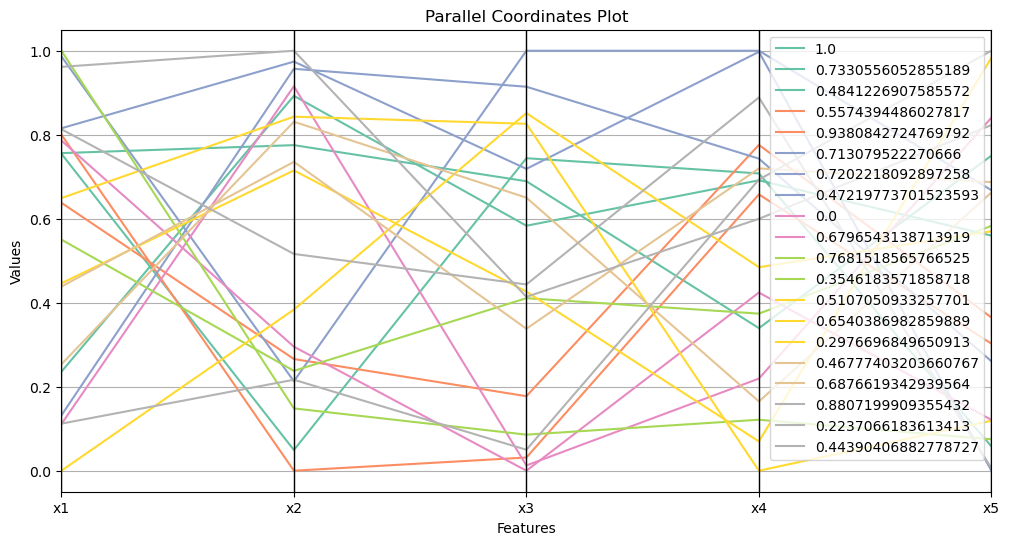

In [31]:
#Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates
# Normalize the data if necessary
df = (df - df.min()) / (df.max() - df.min())

# Create the Parallel Coordinates Plot
plt.figure(figsize=(12, 6))
parallel_coordinates(df, 'output', colormap=plt.get_cmap("Set2"))
plt.title('Parallel Coordinates Plot')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

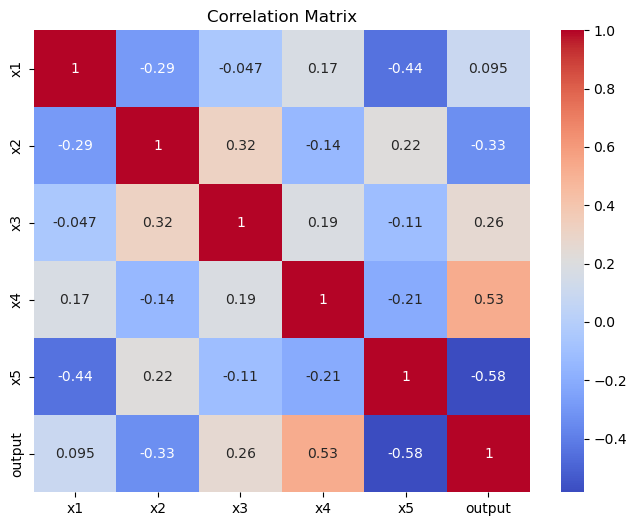

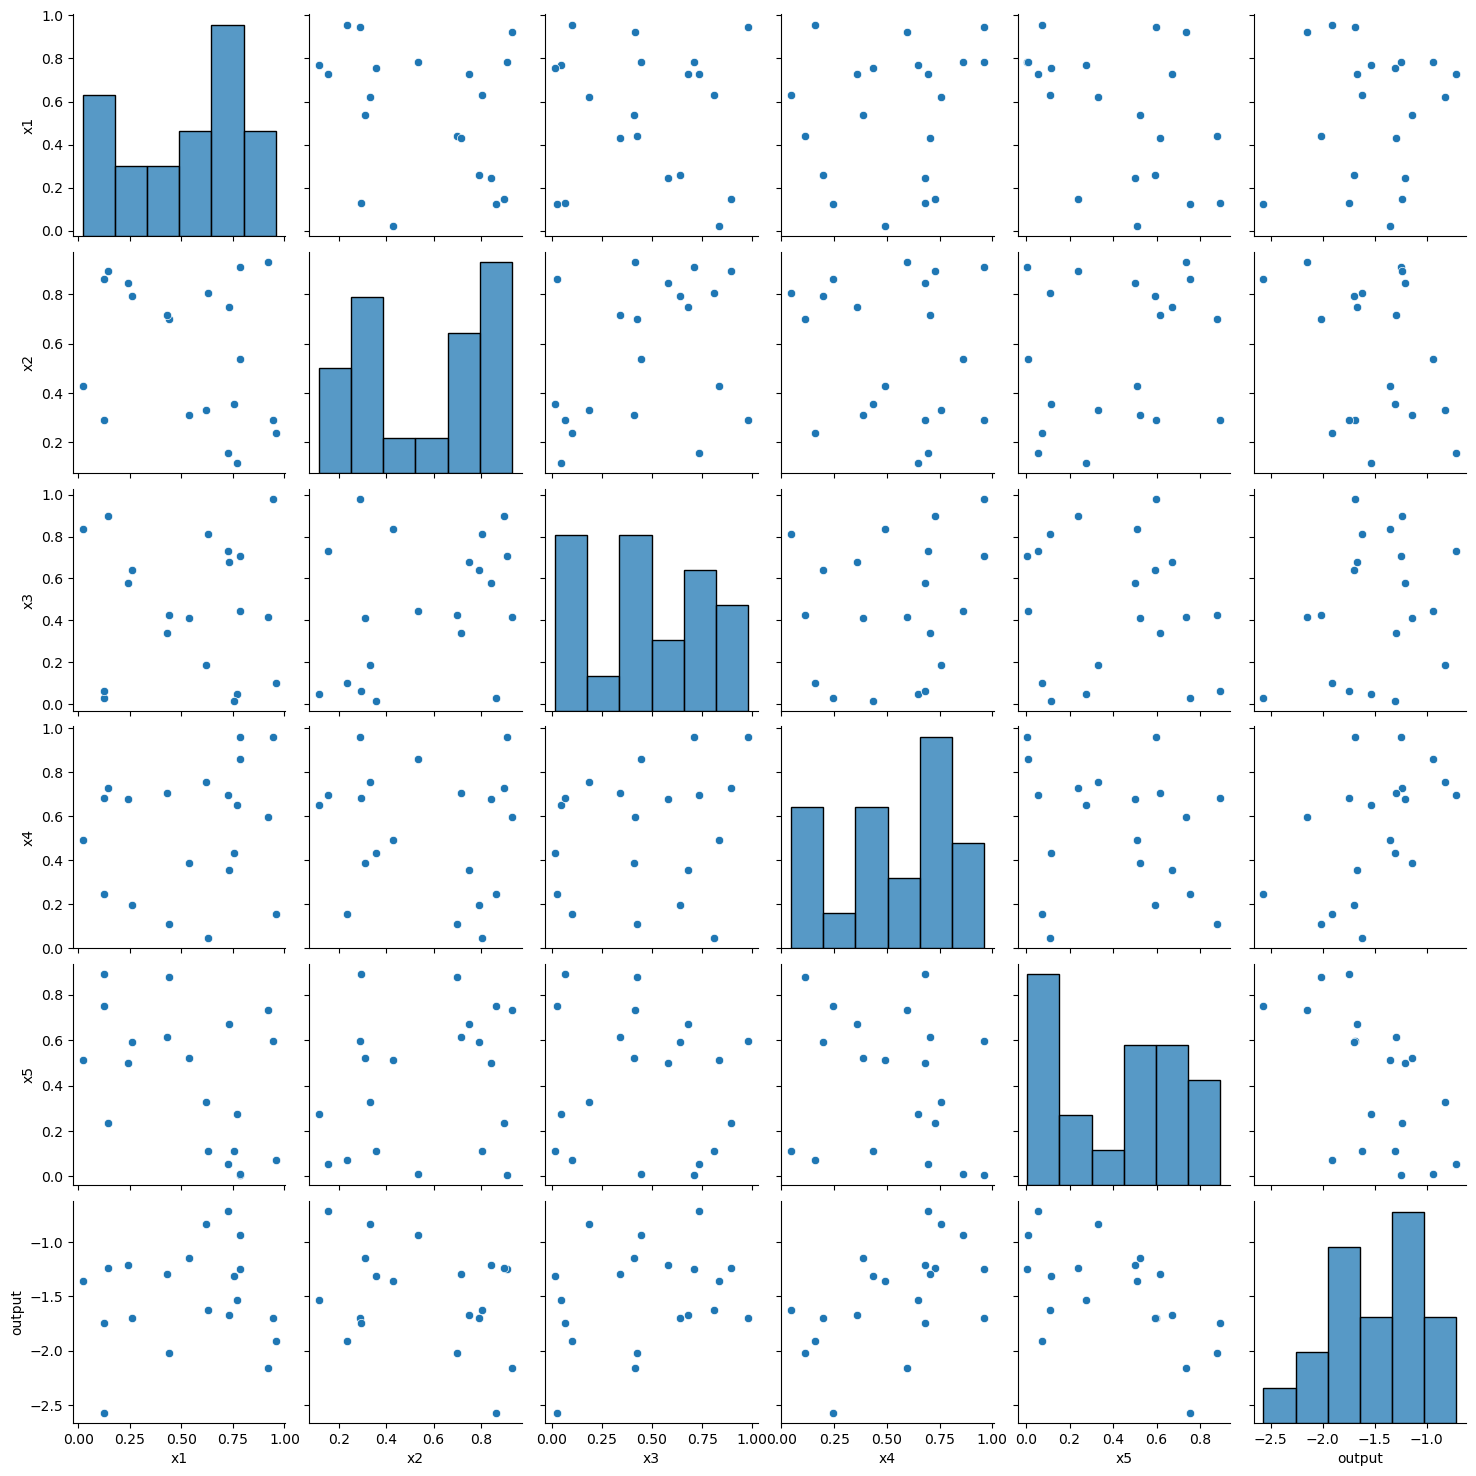

In [16]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

In [17]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)
print("Kappa Array:", kappa_array)
print("Xi Array:", xi_array)

Kappa Array: [1.96       1.764      1.5876     1.42884    1.285956   1.1573604
 1.04162436 0.93746192 0.84371573 0.75934416]
Xi Array: [0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205]


In [18]:
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
    #'k2__noise_level': loguniform(1e-3, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_w1,Y_w1)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

Best Parameters: {'kernel__k1__constant_value': 0.0013289448722869186, 'kernel__k2__length_scale': 65.9871107205407}
Log-marginal-likelihood: -20.974397030074044


In [20]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [21]:
# define multiple acquisition functions

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma

In [22]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

In [23]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb

Next query EI:  0.674500-0.084306-0.943848-0.758556-0.441651
Next query PI:  0.466815-0.199341-0.612600-0.759889-0.192109
Next query UCB:  0.900763-0.000924-0.967903-0.000855-0.987858
MSE: 4.7967577141496945e-20
R-squared: 1.0


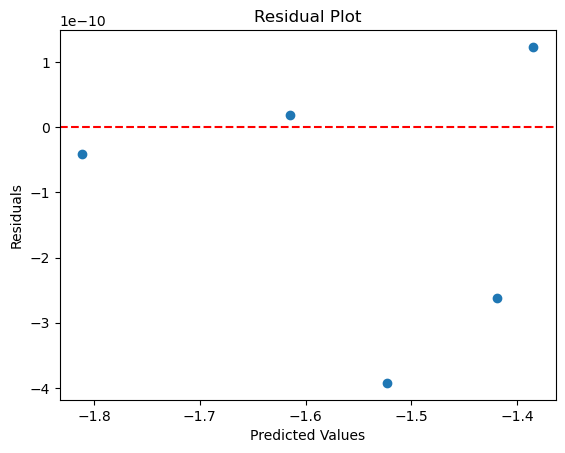

In [26]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 5  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 1  # For week 2, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

In [ ]:
##Aproach 3:  a Sparse Gaussian Process model

In [27]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_w1.ndim == 1:
    Y_w1_2d = Y_w1[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_w1.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_w1, Y_w1_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_w1_new_points)
mse = np.mean((Y_w1_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |               value  |  constraints  |  priors
  variance     |  3.4656323310488624  |      +ve      |        
  lengthscale  |   6.597286363284427  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.12584593  |      +ve      |        
MSE on validation set: 0.058171508266087614


Next query EI:  0.951237-0.015974-0.987161-0.973952-0.011381
Next query PI:  0.951237-0.015974-0.987161-0.973952-0.011381
Next query UCB:  0.951237-0.015974-0.987161-0.973952-0.011381
MSE: 0.04300318391870249
R-squared: -0.8250449959411534


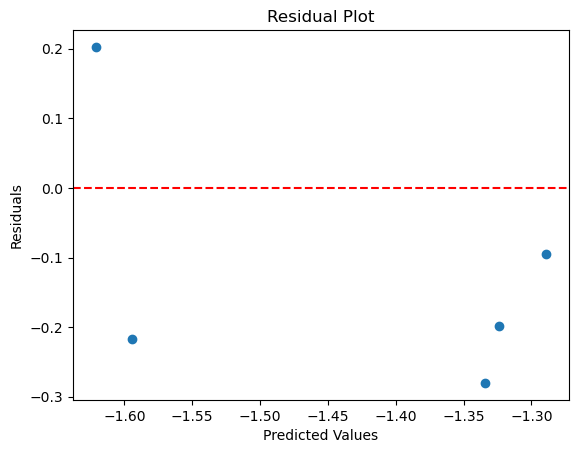

In [28]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

mse, r2 = evaluate_model_performance(gp_sparse, X_w1_new_points, Y_w1_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")